In [3]:
from plotnine import *
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import seaborn as sns
import sys
from siuba import group_by, summarize, filter, mutate, arrange, spread, gather, select, _
from siuba.experimental.pivot import pivot_wider


#### Load data

In [4]:
with open("result_df_full_trials_10000.pkl", "rb") as f:
    result_df = pickle.load(f)

#### Compute coverage rates for Table 1

In [5]:
result_df = result_df >> mutate(is_na = np.isnan(_.lower).astype(int))

In [6]:
agg_df = (result_df >> group_by(_.n, _.L)
          >> summarize(coverage = _.cover.mean(),
                       na_frac = _.is_na.mean())
          >> arrange(_.L))

table_df = (agg_df >> select(_.n, _.L, _.coverage) >> spread(_.n, _.coverage)) 

In [7]:
(agg_df >> select(_.n, _.L, _.na_frac) >> spread(_.n, _.na_frac)) 

,L,1000,2000,3000,4000,5000,10000
0,1,0.2146,0.9985,1.0,1.0,1.0000,1.0000
1,2,0.0000,0.0000,0.0,0.0,0.0046,0.8941
2,3,0.0000,0.0000,0.0,0.0,0.0000,0.0000
3,4,0.0000,0.0000,0.0,0.0,0.0000,0.0000
4,5,0.0000,0.0000,0.0,0.0,0.0000,0.0000
5,inf,0.0000,0.0000,0.0,0.0,0.0000,0.0000


In [8]:
table_df

,L,1000,2000,3000,4000,5000,10000
0,1,0.4075,0.0003,0.0000,0.0000,0.0000,0.0000
1,2,0.5973,0.7247,0.7885,0.8271,0.8591,0.0949
2,3,0.6462,0.7718,0.8279,0.8689,0.8968,0.9693
3,4,0.6821,0.8022,0.8533,0.8908,0.9194,0.9797
4,5,0.7061,0.8203,0.8675,0.9067,0.9311,0.9838
5,inf,0.7503,0.8614,0.9066,0.9347,0.9558,0.9920


In [10]:
table_df.to_csv("yeast_table.txt", header = None, index = None, sep = "&")

#### Plot coverage results for Figure 4

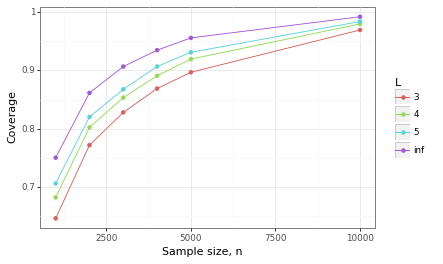

<ggplot: (8763146765960)>

In [9]:
p = (ggplot(agg_df.query("L != '1' and L != '2'"), aes(x = "n", y = "coverage", color ="L", group = "L")) + 
 geom_line() + 
 geom_point() + 
 labs(x = "Sample size, n", y = "Coverage") + 
 theme_bw())
#  theme(legend_position="bottom", legend_box_spacing=0.4)+ 
#  guides(color=guide_legend(nrow=1)))

p

# ggsave(p, "coverage.pdf", width = 5, height = 3)


#### Repeat analysis with eps = 0.005

In [32]:
result_df = result_df >> mutate(cover_001_lower = _.lower - 0.005 < _.pi_e_value, 
                                cover_001_upper = _.upper + 0.005 > _.pi_e_value,
                                cover_001 = _.cover_001_lower*_.cover_001_upper)

result_df["cover_001"] = result_df["cover_001"].astype(int)
result_df

,trial,n,L,lower,upper,cover,pi_e_value,is_na,cover_001_lower,cover_001_upper,cover_001
0,0,1000,1,0.556206,0.558853,0,0.526280,0,False,True,0
1,0,1000,2,0.554551,0.560388,0,0.526280,0,False,True,0
2,0,1000,3,0.553211,0.561651,0,0.526280,0,False,True,0
3,0,1000,4,0.552144,0.562583,0,0.526280,0,False,True,0
4,0,1000,5,0.551364,0.563294,0,0.526280,0,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...
1,9999,10000,2,0.513283,0.518897,1,0.509416,0,True,True,1
2,9999,10000,3,0.512202,0.520578,1,0.509416,0,True,True,1
3,9999,10000,4,0.511449,0.521990,1,0.509416,0,True,True,1
4,9999,10000,5,0.510874,0.523147,1,0.509416,0,True,True,1


In [33]:
agg_df = (result_df >> group_by(_.n, _.L)
          >> summarize(coverage = _.cover_001.mean(),
                       na_frac = _.is_na.mean())
          >> arrange(_.L))

table_df = (agg_df >> select(_.n, _.L, _.coverage) >> spread(_.n, _.coverage)) 

In [34]:
table_df

,L,1000,2000,3000,4000,5000,10000
0,1,0.2379,0.0002,0.0000,0.0000,0.0000,0.0000
1,2,0.3917,0.4928,0.5431,0.5761,0.6028,0.0603
2,3,0.4503,0.5609,0.6128,0.6431,0.6755,0.7650
3,4,0.4977,0.6057,0.6573,0.6854,0.7226,0.8102
4,5,0.5283,0.6324,0.6873,0.7168,0.7516,0.8411
5,inf,0.5905,0.7057,0.7566,0.7887,0.8186,0.8953


In [35]:
table_df.to_csv("yeast_table_005.txt", header = None, index = None, sep = "&")